In [ ]:
#necessary on linux/mac
#import multiprocessing

#if __name__ == '__main__':
#    multiprocessing.set_start_method('forkserver')

In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.preprocessing import Normalizer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score

import datetime
import matplotlib

import matplotlib.pyplot as plt

import DataPrep
import error_evaluation


Using CNTK backend


In [94]:
dp = DataPrep.DataPrep()
df = dp.prep_data(input_file='E:/Data/OAPMLData/V1.1CIAC_UAC_NWAC_FeaturesWithLabels30Days20131201To20180430.csv', ignore_extreme=True, only_critical_points=False, only_precise_points = False, label_critical_points=True)


In [95]:
df.to_pickle('E:/Temp/df.pkl')

In [2]:
df = pd.read_pickle('E:/Temp/df.pkl')

In [3]:
df['UnifiedRegion'].value_counts()

Front Range                    24672
Northern San Juan              23998
Cascade East - South           23828
Olympics                       23459
Cascade East - Central         18746
Cascade West - South           18640
Cascade West - North           18581
Low East                       18058
Southern San Juan              17725
Cascade East - North           16986
Vail & Summit County           15134
Low West                       11468
Aspen                          10608
Sawatch Range                  10565
Uintas                          9381
Sangre de Cristo                8148
Ogden                           7770
Cascade West - Central          7613
In The Desert                   6956
Steamboat & Flat Tops           6600
Logan                           6511
Gunnison                        6150
In The Lake                     6138
Skyline                         4011
Cascade Pass - Snoq. Pass       3936
Salt Lake                       2720
Mt Hood                         2101
C

In [4]:
#label avy centers in training as a feature
df.loc[df['UnifiedRegion'].isin(['Front Range', 'Northern San Juan', 
                                 'Southern San Juan', 'Vail & Summit County', 
                                 'Aspen', 'Sawatch Range', 'Sangre de Cristo',
                                 'Steamboat & Flat Tops', 'Gunnison' ]), 'AvyCenter'] = 2

In [5]:
df.loc[df['UnifiedRegion'].isin(['Cascade East - South', 'Olympics', 'Cascade East - Central',
                                 'Cascade West - North', 'Cascade West - South', 
                                 'Cascade West - Central', 'Low East', 'Cascade East - North',
                                 'Low West', 'Cascade West - Central', 'Cascade Pass - Snoq. Pass',
                                 'Cascade Pass - Stevens Pass', 'Mt Hood']), 'AvyCenter'] = 0

In [6]:
df.loc[df['UnifiedRegion'].isin(['Uintas', 
                                 'Ogden', 'In The Desert', 
                                 'Logan', 'In The Lake', 'Skyline',
                                 'Salt Lake', 'Provo']), 'AvyCenter'] = 1

In [7]:
df['AvyCenter'].isnull().any()

False

In [8]:
yColumns = ['o_Day1DangerAboveTreeline']
metadata_columns = [
            'Lat',
            'Lon',
            'UnifiedRegion',
            'Date',
            'IsCriticalPoint'
            ]
columns_to_keep =  ['n_f_APCPsurface1HourForecast',
                    'n_f_10mWindSpeed1HourForecast',
                    'n_f_APCPsurface2HourForecast',
                    'n_f_10mWindSpeed2HourForecast',
                    'n_f_APCPsurface3HourForecast',
                    'n_f_10mWindSpeed3HourForecast',
                    'n_f_APCPsurface4HourForecast',
                    'n_f_10mWindSpeed4HourForecast',
                    'n_f_APCPsurface5HourForecast',
                    'n_f_10mWindSpeed5HourForecast',
                    'n_f_APCPsurface6HourForecast',
                    'n_f_10mWindSpeed6HourForecast',
                    'n_f_APCPsurface7HourForecast',
                    'n_f_10mWindSpeed7HourForecast',
                    'n_f_APCPsurface8HourForecast',
                    'n_f_10mWindSpeed8HourForecast',
                    'n_f_APCPsurface9HourForecast',
                    'n_f_10mWindSpeed9HourForecast',
                    'n_f_APCPsurface10HourForecast',
                    'n_f_10mWindSpeed10HourForecast',
                    'n_f_APCPsurface11HourForecast',
                    'n_f_10mWindSpeed11HourForecast',
                    'n_f_APCPsurface12HourForecast',
                    'n_f_10mWindSpeed12HourForecast',
                    'n_f_APCPsurface13HourForecast',
                    'n_f_10mWindSpeed13HourForecast',
                    'n_f_APCPsurface14HourForecast',
                    'n_f_10mWindSpeed14HourForecast',
                    'n_f_APCPsurface15HourForecast',
                    'n_f_10mWindSpeed15HourForecast',
                    'n_f_APCPsurface16HourForecast',
                    'n_f_10mWindSpeed16HourForecast',
                    'n_f_APCPsurface17HourForecast',
                    'n_f_10mWindSpeed17HourForecast',
                    'n_f_APCPsurface18HourForecast',
                    'n_f_10mWindSpeed18HourForecast',
                    'n_f_APCPsurface19HourForecast',
                    'n_f_10mWindSpeed19HourForecast',
                    'n_f_APCPsurface20HourForecast',
                    'n_f_10mWindSpeed20HourForecast',
                    'n_f_APCPsurface21HourForecast',
                    'n_f_10mWindSpeed21HourForecast',
                    'n_f_APCPsurface22HourForecast',
                    'n_f_10mWindSpeed22HourForecast',
                    'n_f_APCPsurface23HourForecast',
                    'n_f_10mWindSpeed23HourForecast',
                    'n_f_tempMaxF',
                    'n_f_10mWindSpeedMax',
                    'n_r_snowDepthIn',
                    'n_f_tempMinF',
                    'n_f_tempAveF',
                    'n_f_10mWindSpeed',
                    'n_f_APCPsurface',
                    'n_r_precipIncrementSnowIn',
                    'n_r_Prev3daySnowAccumulation',
                    'n_r_Prev7daySnowAccumulation',
                    'n_r_Prev3dayMaxTemp',
                    'n_r_Prev3DayMax10mWind',
                    'n_r_Prev3dayMinTemp',
                    'n_r_Prev7dayMaxTemp',
                    'n_r_Prev7DayMax10mWind',
                    'n_r_Prev7dayMinTemp',
                    'n_r_Prev1dayMaxTemp',
                    'n_r_Prev1DayMax10mWind',
                    'n_r_Prev1dayMinTemp',
                    'n_r_Prev1DayPrecip',
                    'n_f_Next24HourChangeInTempFromPrev3DayMax',
                    'n_f_Next24HoursChangeInTempFromPrev1DayMax',
                    'n_r_Prev24HoursPrecipAsRainTotalIn',
                    'n_r_SNOWDAS_SnowDepth_mm',
                    'n_r_SNOWDAS_SWE_mm',
                    'n_r_SNOWDAS_SnowmeltRunoff_micromm',
                    'n_r_SNOWDAS_Sublimation_micromm',
                    'n_r_SNOWDAS_SolidPrecip_kgpersquarem',
                    'n_r_SNOWDAS_LiquidPrecip_kgpersquarem',
                    'n_r_SNOWDAS_SnowpackAveTemp_k',
                    'n_r_snowDepthIn1InPast',
                    'n_r_precipIncrementSnowIn1InPast',
                    'n_r_Prev3daySnowAccumulation1InPast',
                    'n_r_Prev7daySnowAccumulation1InPast',
                    'n_r_Prev3dayMaxTemp1InPast',
                    'n_r_Prev3DayMax10mWind1InPast',
                    'n_r_Prev3dayMinTemp1InPast',
                    'n_r_Prev7dayMaxTemp1InPast',
                    'n_r_Prev7DayMax10mWind1InPast',
                    'n_r_Prev7dayMinTemp1InPast',
                    'n_r_Prev1dayMaxTemp1InPast',
                    'n_r_Prev1DayMax10mWind1InPast',
                    'n_r_Prev1dayMinTemp1InPast',
                    'n_r_Prev1DayPrecip1InPast',
                    'n_r_Prev24HoursPrecipAsRainTotalIn1InPast',
                    'n_r_SNOWDAS_SnowDepth_mm1InPast',
                    'n_r_SNOWDAS_SWE_mm1InPast',
                    'n_r_SNOWDAS_SnowmeltRunoff_micromm1InPast',
                    'n_r_SNOWDAS_Sublimation_micromm1InPast',
                    'n_r_SNOWDAS_SolidPrecip_kgpersquarem1InPast',
                    'n_r_SNOWDAS_LiquidPrecip_kgpersquarem1InPast',
                    'n_r_SNOWDAS_SnowpackAveTemp_k1InPast',
                    'n_r_snowDepthIn2InPast',
                    'n_r_precipIncrementSnowIn2InPast',
                    'n_r_Prev3daySnowAccumulation2InPast',
                    'n_r_Prev7daySnowAccumulation2InPast',
                    'n_r_Prev3dayMaxTemp2InPast',
                    'n_r_Prev3DayMax10mWind2InPast',
                    'n_r_Prev3dayMinTemp2InPast',
                    'n_r_Prev7dayMaxTemp2InPast',
                    'n_r_Prev7DayMax10mWind2InPast',
                    'n_r_Prev7dayMinTemp2InPast',
                    'n_r_Prev1dayMaxTemp2InPast',
                    'n_r_Prev1DayMax10mWind2InPast',
                    'n_r_Prev1dayMinTemp2InPast',
                    'n_r_Prev1DayPrecip2InPast',
                    'n_r_Prev24HoursPrecipAsRainTotalIn2InPast',
                    'n_r_SNOWDAS_SnowDepth_mm2InPast',
                    'n_r_SNOWDAS_SWE_mm2InPast',
                    'n_r_SNOWDAS_SnowmeltRunoff_micromm2InPast',
                    'n_r_SNOWDAS_Sublimation_micromm2InPast',
                    'n_r_SNOWDAS_SolidPrecip_kgpersquarem2InPast',
                    'n_r_SNOWDAS_LiquidPrecip_kgpersquarem2InPast',
                    'n_r_SNOWDAS_SnowpackAveTemp_k2InPast',
                    'n_r_snowDepthIn3InPast',
                    'n_r_precipIncrementSnowIn3InPast',
                    'n_r_Prev3daySnowAccumulation3InPast',
                    'n_r_Prev7daySnowAccumulation3InPast',
                    'n_r_Prev3dayMaxTemp3InPast',
                    'n_r_Prev3DayMax10mWind3InPast',
                    'n_r_Prev3dayMinTemp3InPast',
                    'n_r_Prev7dayMaxTemp3InPast',
                    'n_r_Prev7DayMax10mWind3InPast',
                    'n_r_Prev7dayMinTemp3InPast',
                    'n_r_Prev1dayMaxTemp3InPast',
                    'n_r_Prev1DayMax10mWind3InPast',
                    'n_r_Prev1dayMinTemp3InPast',
                    'n_r_Prev1DayPrecip3InPast',
                    'n_r_Prev24HoursPrecipAsRainTotalIn3InPast',
                    'n_r_SNOWDAS_SnowDepth_mm3InPast',
                    'n_r_SNOWDAS_SWE_mm3InPast',
                    'n_r_SNOWDAS_SnowmeltRunoff_micromm3InPast',
                    'n_r_SNOWDAS_Sublimation_micromm3InPast',
                    'n_r_SNOWDAS_SolidPrecip_kgpersquarem3InPast',
                    'n_r_SNOWDAS_LiquidPrecip_kgpersquarem3InPast',
                    'n_r_SNOWDAS_SnowpackAveTemp_k3InPast',
                    'n_r_snowDepthIn4InPast',
                    'n_r_precipIncrementSnowIn4InPast',
                    'n_r_Prev3daySnowAccumulation4InPast',
                    'n_r_Prev7daySnowAccumulation4InPast',
                    'n_r_Prev3dayMaxTemp4InPast',
                    'n_r_Prev3DayMax10mWind4InPast',
                    'n_r_Prev3dayMinTemp4InPast',
                    'n_r_Prev7dayMaxTemp4InPast',
                    'n_r_Prev7DayMax10mWind4InPast',
                    'n_r_Prev7dayMinTemp4InPast',
                    'n_r_Prev1dayMaxTemp4InPast',
                    'n_r_Prev1DayMax10mWind4InPast',
                    'n_r_Prev1dayMinTemp4InPast',
                    'n_r_Prev1DayPrecip4InPast',
                    'n_r_Prev24HoursPrecipAsRainTotalIn4InPast',
                    'n_r_SNOWDAS_SnowDepth_mm4InPast',
                    'n_r_SNOWDAS_SWE_mm4InPast',
                    'n_r_SNOWDAS_SnowmeltRunoff_micromm4InPast',
                    'n_r_SNOWDAS_Sublimation_micromm4InPast',
                    'n_r_SNOWDAS_SolidPrecip_kgpersquarem4InPast',
                    'n_r_SNOWDAS_LiquidPrecip_kgpersquarem4InPast',
                    'n_r_SNOWDAS_SnowpackAveTemp_k4InPast',
                    'n_r_snowDepthIn5InPast',
                    'n_r_precipIncrementSnowIn5InPast',
                    'n_r_Prev3daySnowAccumulation5InPast',
                    'n_r_Prev7daySnowAccumulation5InPast',
                    'n_r_Prev3dayMaxTemp5InPast',
                    'n_r_Prev3DayMax10mWind5InPast',
                    'n_r_Prev3dayMinTemp5InPast',
                    'n_r_Prev7dayMaxTemp5InPast',
                    'n_r_Prev7DayMax10mWind5InPast',
                    'n_r_Prev7dayMinTemp5InPast',
                    'n_r_Prev1dayMaxTemp5InPast',
                    'n_r_Prev1DayMax10mWind5InPast',
                    'n_r_Prev1dayMinTemp5InPast',
                    'n_r_Prev1DayPrecip5InPast',
                    'n_r_Prev24HoursPrecipAsRainTotalIn5InPast',
                    'n_r_SNOWDAS_SnowDepth_mm5InPast',
                    'n_r_SNOWDAS_SWE_mm5InPast',
                    'n_r_SNOWDAS_SnowmeltRunoff_micromm5InPast',
                    'n_r_SNOWDAS_Sublimation_micromm5InPast',
                    'n_r_SNOWDAS_SolidPrecip_kgpersquarem5InPast',
                    'n_r_SNOWDAS_LiquidPrecip_kgpersquarem5InPast',
                    'n_r_SNOWDAS_SnowpackAveTemp_k5InPast',
                    'n_r_snowDepthIn6InPast',
                    'n_r_precipIncrementSnowIn6InPast',
                    'n_r_Prev3daySnowAccumulation6InPast',
                    'n_r_Prev7daySnowAccumulation6InPast',
                    'n_r_Prev3dayMaxTemp6InPast',
                    'n_r_Prev3DayMax10mWind6InPast',
                    'n_r_Prev3dayMinTemp6InPast',
                    'n_r_Prev7dayMaxTemp6InPast',
                    'n_r_Prev7DayMax10mWind6InPast',
                    'n_r_Prev7dayMinTemp6InPast',
                    'n_r_Prev1dayMaxTemp6InPast',
                    'n_r_Prev1DayMax10mWind6InPast',
                    'n_r_Prev1dayMinTemp6InPast',
                    'n_r_Prev1DayPrecip6InPast',
                    'n_r_Prev24HoursPrecipAsRainTotalIn6InPast',
                    'n_r_SNOWDAS_SnowDepth_mm6InPast',
                    'n_r_SNOWDAS_SWE_mm6InPast',
                    'n_r_SNOWDAS_SnowmeltRunoff_micromm6InPast',
                    'n_r_SNOWDAS_Sublimation_micromm6InPast',
                    'n_r_SNOWDAS_SolidPrecip_kgpersquarem6InPast',
                    'n_r_SNOWDAS_LiquidPrecip_kgpersquarem6InPast',
                    'n_r_SNOWDAS_SnowpackAveTemp_k6InPast',
                    'n_r_snowDepthIn7InPast',
                    'n_r_precipIncrementSnowIn7InPast',
                    'n_r_Prev3daySnowAccumulation7InPast',
                    'n_r_Prev7daySnowAccumulation7InPast',
                    'n_r_Prev3dayMaxTemp7InPast',
                    'n_r_Prev3DayMax10mWind7InPast',
                    'n_r_Prev3dayMinTemp7InPast',
                    'n_r_Prev7dayMaxTemp7InPast',
                    'n_r_Prev7DayMax10mWind7InPast',
                    'n_r_Prev7dayMinTemp7InPast',
                    'n_r_Prev1dayMaxTemp7InPast',
                    'n_r_Prev1DayMax10mWind7InPast',
                    'n_r_Prev1dayMinTemp7InPast',
                    'n_r_Prev1DayPrecip7InPast',
                    'n_r_Prev24HoursPrecipAsRainTotalIn7InPast',
                    'n_r_SNOWDAS_SnowDepth_mm7InPast',
                    'n_r_SNOWDAS_SWE_mm7InPast',
                    'n_r_SNOWDAS_SnowmeltRunoff_micromm7InPast',
                    'n_r_SNOWDAS_Sublimation_micromm7InPast',
                    'n_r_SNOWDAS_SolidPrecip_kgpersquarem7InPast',
                    'n_r_SNOWDAS_LiquidPrecip_kgpersquarem7InPast',
                    'n_r_SNOWDAS_SnowpackAveTemp_k7InPast',
                    'n_r_snowDepthIn8InPast',
                    'n_r_precipIncrementSnowIn8InPast',
                    'n_r_Prev3daySnowAccumulation8InPast',
                    'n_r_Prev7daySnowAccumulation8InPast',
                    'n_r_Prev3dayMaxTemp8InPast',
                    'n_r_Prev3DayMax10mWind8InPast',
                    'n_r_Prev3dayMinTemp8InPast',
                    'n_r_Prev7dayMaxTemp8InPast',
                    'n_r_Prev7DayMax10mWind8InPast',
                    'n_r_Prev7dayMinTemp8InPast',
                    'n_r_Prev1dayMaxTemp8InPast',
                    'n_r_Prev1DayMax10mWind8InPast',
                    'n_r_Prev1dayMinTemp8InPast',
                    'n_r_Prev1DayPrecip8InPast',
                    'n_r_Prev24HoursPrecipAsRainTotalIn8InPast',
                    'n_r_SNOWDAS_SnowDepth_mm8InPast',
                    'n_r_SNOWDAS_SWE_mm8InPast',
                    'n_r_SNOWDAS_SnowmeltRunoff_micromm8InPast',
                    'n_r_SNOWDAS_Sublimation_micromm8InPast',
                    'n_r_SNOWDAS_SolidPrecip_kgpersquarem8InPast',
                    'n_r_SNOWDAS_LiquidPrecip_kgpersquarem8InPast',
                    'n_r_SNOWDAS_SnowpackAveTemp_k8InPast',
                    'n_r_snowDepthIn9InPast',
                    'n_r_precipIncrementSnowIn9InPast',
                    'n_r_Prev3daySnowAccumulation9InPast',
                    'n_r_Prev7daySnowAccumulation9InPast',
                    'n_r_Prev3dayMaxTemp9InPast',
                    'n_r_Prev3DayMax10mWind9InPast',
                    'n_r_Prev3dayMinTemp9InPast',
                    'n_r_Prev7dayMaxTemp9InPast',
                    'n_r_Prev7DayMax10mWind9InPast',
                    'n_r_Prev7dayMinTemp9InPast',
                    'n_r_Prev1dayMaxTemp9InPast',
                    'n_r_Prev1DayMax10mWind9InPast',
                    'n_r_Prev1dayMinTemp9InPast',
                    'n_r_Prev1DayPrecip9InPast',
                    'n_r_Prev24HoursPrecipAsRainTotalIn9InPast',
                    'n_r_SNOWDAS_SnowDepth_mm9InPast',
                    'n_r_SNOWDAS_SWE_mm9InPast',
                    'n_r_SNOWDAS_SnowmeltRunoff_micromm9InPast',
                    'n_r_SNOWDAS_Sublimation_micromm9InPast',
                    'n_r_SNOWDAS_SolidPrecip_kgpersquarem9InPast',
                    'n_r_SNOWDAS_LiquidPrecip_kgpersquarem9InPast',
                    'n_r_SNOWDAS_SnowpackAveTemp_k9InPast',
                    'n_r_snowDepthIn10InPast',
                    'n_r_precipIncrementSnowIn10InPast',
                    'n_r_Prev3daySnowAccumulation10InPast',
                    'n_r_Prev7daySnowAccumulation10InPast',
                    'n_r_Prev3dayMaxTemp10InPast',
                    'n_r_Prev3DayMax10mWind10InPast',
                    'n_r_Prev3dayMinTemp10InPast',
                    'n_r_Prev7dayMaxTemp10InPast',
                    'n_r_Prev7DayMax10mWind10InPast',
                    'n_r_Prev7dayMinTemp10InPast',
                    'n_r_Prev1dayMaxTemp10InPast',
                    'n_r_Prev1DayMax10mWind10InPast',
                    'n_r_Prev1dayMinTemp10InPast',
                    'n_r_Prev1DayPrecip10InPast',
                    'n_r_Prev24HoursPrecipAsRainTotalIn10InPast',
                    'n_r_SNOWDAS_SnowDepth_mm10InPast',
                    'n_r_SNOWDAS_SWE_mm10InPast',
                    'n_r_SNOWDAS_SnowmeltRunoff_micromm10InPast',
                    'n_r_SNOWDAS_Sublimation_micromm10InPast',
                    'n_r_SNOWDAS_SolidPrecip_kgpersquarem10InPast',
                    'n_r_SNOWDAS_LiquidPrecip_kgpersquarem10InPast',
                    'n_r_SNOWDAS_SnowpackAveTemp_k10InPast',
                    'n_r_snowDepthIn11InPast',
                    'n_r_precipIncrementSnowIn11InPast',
                    'n_r_Prev3daySnowAccumulation11InPast',
                    'n_r_Prev7daySnowAccumulation11InPast',
                    'n_r_Prev3dayMaxTemp11InPast',
                    'n_r_Prev3DayMax10mWind11InPast',
                    'n_r_Prev3dayMinTemp11InPast',
                    'n_r_Prev7dayMaxTemp11InPast',
                    'n_r_Prev7DayMax10mWind11InPast',
                    'n_r_Prev7dayMinTemp11InPast',
                    'n_r_Prev1dayMaxTemp11InPast',
                    'n_r_Prev1DayMax10mWind11InPast',
                    'n_r_Prev1dayMinTemp11InPast',
                    'n_r_Prev1DayPrecip11InPast',
                    'n_r_Prev24HoursPrecipAsRainTotalIn11InPast',
                    'n_r_SNOWDAS_SnowDepth_mm11InPast',
                    'n_r_SNOWDAS_SWE_mm11InPast',
                    'n_r_SNOWDAS_SnowmeltRunoff_micromm11InPast',
                    'n_r_SNOWDAS_Sublimation_micromm11InPast',
                    'n_r_SNOWDAS_SolidPrecip_kgpersquarem11InPast',
                    'n_r_SNOWDAS_LiquidPrecip_kgpersquarem11InPast',
                    'n_r_SNOWDAS_SnowpackAveTemp_k11InPast',
                    'n_r_snowDepthIn12InPast',
                    'n_r_precipIncrementSnowIn12InPast',
                    'n_r_Prev3daySnowAccumulation12InPast',
                    'n_r_Prev7daySnowAccumulation12InPast',
                    'n_r_Prev3dayMaxTemp12InPast',
                    'n_r_Prev3DayMax10mWind12InPast',
                    'n_r_Prev3dayMinTemp12InPast',
                    'n_r_Prev7dayMaxTemp12InPast',
                    'n_r_Prev7DayMax10mWind12InPast',
                    'n_r_Prev7dayMinTemp12InPast',
                    'n_r_Prev1dayMaxTemp12InPast',
                    'n_r_Prev1DayMax10mWind12InPast',
                    'n_r_Prev1dayMinTemp12InPast',
                    'n_r_Prev1DayPrecip12InPast',
                    'n_r_Prev24HoursPrecipAsRainTotalIn12InPast',
                    'n_r_SNOWDAS_SnowDepth_mm12InPast',
                    'n_r_SNOWDAS_SWE_mm12InPast',
                    'n_r_SNOWDAS_SnowmeltRunoff_micromm12InPast',
                    'n_r_SNOWDAS_Sublimation_micromm12InPast',
                    'n_r_SNOWDAS_SolidPrecip_kgpersquarem12InPast',
                    'n_r_SNOWDAS_LiquidPrecip_kgpersquarem12InPast',
                    'n_r_SNOWDAS_SnowpackAveTemp_k12InPast',
                    'n_r_snowDepthIn13InPast',
                    'n_r_precipIncrementSnowIn13InPast',
                    'n_r_Prev3daySnowAccumulation13InPast',
                    'n_r_Prev7daySnowAccumulation13InPast',
                    'n_r_Prev3dayMaxTemp13InPast',
                    'n_r_Prev3DayMax10mWind13InPast',
                    'n_r_Prev3dayMinTemp13InPast',
                    'n_r_Prev7dayMaxTemp13InPast',
                    'n_r_Prev7DayMax10mWind13InPast',
                    'n_r_Prev7dayMinTemp13InPast',
                    'n_r_Prev1dayMaxTemp13InPast',
                    'n_r_Prev1DayMax10mWind13InPast',
                    'n_r_Prev1dayMinTemp13InPast',
                    'n_r_Prev1DayPrecip13InPast',
                    'n_r_Prev24HoursPrecipAsRainTotalIn13InPast',
                    'n_r_SNOWDAS_SnowDepth_mm13InPast',
                    'n_r_SNOWDAS_SWE_mm13InPast',
                    'n_r_SNOWDAS_SnowmeltRunoff_micromm13InPast',
                    'n_r_SNOWDAS_Sublimation_micromm13InPast',
                    'n_r_SNOWDAS_SolidPrecip_kgpersquarem13InPast',
                    'n_r_SNOWDAS_LiquidPrecip_kgpersquarem13InPast',
                    'n_r_SNOWDAS_SnowpackAveTemp_k13InPast',
                    'n_r_snowDepthIn14InPast',
                    'n_r_precipIncrementSnowIn14InPast',
                    'n_r_Prev3daySnowAccumulation14InPast',
                    'n_r_Prev7daySnowAccumulation14InPast',
                    'n_r_Prev3dayMaxTemp14InPast',
                    'n_r_Prev3DayMax10mWind14InPast',
                    'n_r_Prev3dayMinTemp14InPast',
                    'n_r_Prev7dayMaxTemp14InPast',
                    'n_r_Prev7DayMax10mWind14InPast',
                    'n_r_Prev7dayMinTemp14InPast',
                    'n_r_Prev1dayMaxTemp14InPast',
                    'n_r_Prev1DayMax10mWind14InPast',
                    'n_r_Prev1dayMinTemp14InPast',
                    'n_r_Prev1DayPrecip14InPast',
                    'n_r_Prev24HoursPrecipAsRainTotalIn14InPast',
                    'n_r_SNOWDAS_SnowDepth_mm14InPast',
                    'n_r_SNOWDAS_SWE_mm14InPast',
                    'n_r_SNOWDAS_SnowmeltRunoff_micromm14InPast',
                    'n_r_SNOWDAS_Sublimation_micromm14InPast',
                    'n_r_SNOWDAS_SolidPrecip_kgpersquarem14InPast',
                    'n_r_SNOWDAS_LiquidPrecip_kgpersquarem14InPast',
                    'n_r_SNOWDAS_SnowpackAveTemp_k14InPast',
                    'n_r_snowDepthIn15InPast',
                    'n_r_precipIncrementSnowIn15InPast',
                    'n_r_Prev3daySnowAccumulation15InPast',
                    'n_r_Prev7daySnowAccumulation15InPast',
                    'n_r_Prev3dayMaxTemp15InPast',
                    'n_r_Prev3DayMax10mWind15InPast',
                    'n_r_Prev3dayMinTemp15InPast',
                    'n_r_Prev7dayMaxTemp15InPast',
                    'n_r_Prev7DayMax10mWind15InPast',
                    'n_r_Prev7dayMinTemp15InPast',
                    'n_r_Prev1dayMaxTemp15InPast',
                    'n_r_Prev1DayMax10mWind15InPast',
                    'n_r_Prev1dayMinTemp15InPast',
                    'n_r_Prev1DayPrecip15InPast',
                    'n_r_Prev24HoursPrecipAsRainTotalIn15InPast',
                    'n_r_SNOWDAS_SnowDepth_mm15InPast',
                    'n_r_SNOWDAS_SWE_mm15InPast',
                    'n_r_SNOWDAS_SnowmeltRunoff_micromm15InPast',
                    'n_r_SNOWDAS_Sublimation_micromm15InPast',
                    'n_r_SNOWDAS_SolidPrecip_kgpersquarem15InPast',
                    'n_r_SNOWDAS_LiquidPrecip_kgpersquarem15InPast',
                    'n_r_SNOWDAS_SnowpackAveTemp_k15InPast',
                    'n_r_snowDepthIn16InPast',
                    'n_r_precipIncrementSnowIn16InPast',
                    'n_r_Prev3daySnowAccumulation16InPast',
                    'n_r_Prev7daySnowAccumulation16InPast',
                    'n_r_Prev3dayMaxTemp16InPast',
                    'n_r_Prev3DayMax10mWind16InPast',
                    'n_r_Prev3dayMinTemp16InPast',
                    'n_r_Prev7dayMaxTemp16InPast',
                    'n_r_Prev7DayMax10mWind16InPast',
                    'n_r_Prev7dayMinTemp16InPast',
                    'n_r_Prev1dayMaxTemp16InPast',
                    'n_r_Prev1DayMax10mWind16InPast',
                    'n_r_Prev1dayMinTemp16InPast',
                    'n_r_Prev1DayPrecip16InPast',
                    'n_r_Prev24HoursPrecipAsRainTotalIn16InPast',
                    'n_r_SNOWDAS_SnowDepth_mm16InPast',
                    'n_r_SNOWDAS_SWE_mm16InPast',
                    'n_r_SNOWDAS_SnowmeltRunoff_micromm16InPast',
                    'n_r_SNOWDAS_Sublimation_micromm16InPast',
                    'n_r_SNOWDAS_SolidPrecip_kgpersquarem16InPast',
                    'n_r_SNOWDAS_LiquidPrecip_kgpersquarem16InPast',
                    'n_r_SNOWDAS_SnowpackAveTemp_k16InPast',
                    'n_r_snowDepthIn17InPast',
                    'n_r_precipIncrementSnowIn17InPast',
                    'n_r_Prev3daySnowAccumulation17InPast',
                    'n_r_Prev7daySnowAccumulation17InPast',
                    'n_r_Prev3dayMaxTemp17InPast',
                    'n_r_Prev3DayMax10mWind17InPast',
                    'n_r_Prev3dayMinTemp17InPast',
                    'n_r_Prev7dayMaxTemp17InPast',
                    'n_r_Prev7DayMax10mWind17InPast',
                    'n_r_Prev7dayMinTemp17InPast',
                    'n_r_Prev1dayMaxTemp17InPast',
                    'n_r_Prev1DayMax10mWind17InPast',
                    'n_r_Prev1dayMinTemp17InPast',
                    'n_r_Prev1DayPrecip17InPast',
                    'n_r_Prev24HoursPrecipAsRainTotalIn17InPast',
                    'n_r_SNOWDAS_SnowDepth_mm17InPast',
                    'n_r_SNOWDAS_SWE_mm17InPast',
                    'n_r_SNOWDAS_SnowmeltRunoff_micromm17InPast',
                    'n_r_SNOWDAS_Sublimation_micromm17InPast',
                    'n_r_SNOWDAS_SolidPrecip_kgpersquarem17InPast',
                    'n_r_SNOWDAS_LiquidPrecip_kgpersquarem17InPast',
                    'n_r_SNOWDAS_SnowpackAveTemp_k17InPast',
                    'n_r_snowDepthIn18InPast',
                    'n_r_precipIncrementSnowIn18InPast',
                    'n_r_Prev3daySnowAccumulation18InPast',
                    'n_r_Prev7daySnowAccumulation18InPast',
                    'n_r_Prev3dayMaxTemp18InPast',
                    'n_r_Prev3DayMax10mWind18InPast',
                    'n_r_Prev3dayMinTemp18InPast',
                    'n_r_Prev7dayMaxTemp18InPast',
                    'n_r_Prev7DayMax10mWind18InPast',
                    'n_r_Prev7dayMinTemp18InPast',
                    'n_r_Prev1dayMaxTemp18InPast',
                    'n_r_Prev1DayMax10mWind18InPast',
                    'n_r_Prev1dayMinTemp18InPast',
                    'n_r_Prev1DayPrecip18InPast',
                    'n_r_Prev24HoursPrecipAsRainTotalIn18InPast',
                    'n_r_SNOWDAS_SnowDepth_mm18InPast',
                    'n_r_SNOWDAS_SWE_mm18InPast',
                    'n_r_SNOWDAS_SnowmeltRunoff_micromm18InPast',
                    'n_r_SNOWDAS_Sublimation_micromm18InPast',
                    'n_r_SNOWDAS_SolidPrecip_kgpersquarem18InPast',
                    'n_r_SNOWDAS_LiquidPrecip_kgpersquarem18InPast',
                    'n_r_SNOWDAS_SnowpackAveTemp_k18InPast',
                    'n_r_snowDepthIn19InPast',
                    'n_r_precipIncrementSnowIn19InPast',
                    'n_r_Prev3daySnowAccumulation19InPast',
                    'n_r_Prev7daySnowAccumulation19InPast',
                    'n_r_Prev3dayMaxTemp19InPast',
                    'n_r_Prev3DayMax10mWind19InPast',
                    'n_r_Prev3dayMinTemp19InPast',
                    'n_r_Prev7dayMaxTemp19InPast',
                    'n_r_Prev7DayMax10mWind19InPast',
                    'n_r_Prev7dayMinTemp19InPast',
                    'n_r_Prev1dayMaxTemp19InPast',
                    'n_r_Prev1DayMax10mWind19InPast',
                    'n_r_Prev1dayMinTemp19InPast',
                    'n_r_Prev1DayPrecip19InPast',
                    'n_r_Prev24HoursPrecipAsRainTotalIn19InPast',
                    'n_r_SNOWDAS_SnowDepth_mm19InPast',
                    'n_r_SNOWDAS_SWE_mm19InPast',
                    'n_r_SNOWDAS_SnowmeltRunoff_micromm19InPast',
                    'n_r_SNOWDAS_Sublimation_micromm19InPast',
                    'n_r_SNOWDAS_SolidPrecip_kgpersquarem19InPast',
                    'n_r_SNOWDAS_LiquidPrecip_kgpersquarem19InPast',
                    'n_r_SNOWDAS_SnowpackAveTemp_k19InPast',
                    'n_r_snowDepthIn20InPast',
                    'n_r_precipIncrementSnowIn20InPast',
                    'n_r_Prev3daySnowAccumulation20InPast',
                    'n_r_Prev7daySnowAccumulation20InPast',
                    'n_r_Prev3dayMaxTemp20InPast',
                    'n_r_Prev3DayMax10mWind20InPast',
                    'n_r_Prev3dayMinTemp20InPast',
                    'n_r_Prev7dayMaxTemp20InPast',
                    'n_r_Prev7DayMax10mWind20InPast',
                    'n_r_Prev7dayMinTemp20InPast',
                    'n_r_Prev1dayMaxTemp20InPast',
                    'n_r_Prev1DayMax10mWind20InPast',
                    'n_r_Prev1dayMinTemp20InPast',
                    'n_r_Prev1DayPrecip20InPast',
                    'n_r_Prev24HoursPrecipAsRainTotalIn20InPast',
                    'n_r_SNOWDAS_SnowDepth_mm20InPast',
                    'n_r_SNOWDAS_SWE_mm20InPast',
                    'n_r_SNOWDAS_SnowmeltRunoff_micromm20InPast',
                    'n_r_SNOWDAS_Sublimation_micromm20InPast',
                    'n_r_SNOWDAS_SolidPrecip_kgpersquarem20InPast',
                    'n_r_SNOWDAS_LiquidPrecip_kgpersquarem20InPast',
                    'n_r_SNOWDAS_SnowpackAveTemp_k20InPast',
                    'n_r_snowDepthIn21InPast',
                    'n_r_precipIncrementSnowIn21InPast',
                    'n_r_Prev3daySnowAccumulation21InPast',
                    'n_r_Prev7daySnowAccumulation21InPast',
                    'n_r_Prev3dayMaxTemp21InPast',
                    'n_r_Prev3DayMax10mWind21InPast',
                    'n_r_Prev3dayMinTemp21InPast',
                    'n_r_Prev7dayMaxTemp21InPast',
                    'n_r_Prev7DayMax10mWind21InPast',
                    'n_r_Prev7dayMinTemp21InPast',
                    'n_r_Prev1dayMaxTemp21InPast',
                    'n_r_Prev1DayMax10mWind21InPast',
                    'n_r_Prev1dayMinTemp21InPast',
                    'n_r_Prev1DayPrecip21InPast',
                    'n_r_Prev24HoursPrecipAsRainTotalIn21InPast',
                    'n_r_SNOWDAS_SnowDepth_mm21InPast',
                    'n_r_SNOWDAS_SWE_mm21InPast',
                    'n_r_SNOWDAS_SnowmeltRunoff_micromm21InPast',
                    'n_r_SNOWDAS_Sublimation_micromm21InPast',
                    'n_r_SNOWDAS_SolidPrecip_kgpersquarem21InPast',
                    'n_r_SNOWDAS_LiquidPrecip_kgpersquarem21InPast',
                    'n_r_SNOWDAS_SnowpackAveTemp_k21InPast',
                    'n_r_snowDepthIn22InPast',
                    'n_r_precipIncrementSnowIn22InPast',
                    'n_r_Prev3daySnowAccumulation22InPast',
                    'n_r_Prev7daySnowAccumulation22InPast',
                    'n_r_Prev3dayMaxTemp22InPast',
                    'n_r_Prev3DayMax10mWind22InPast',
                    'n_r_Prev3dayMinTemp22InPast',
                    'n_r_Prev7dayMaxTemp22InPast',
                    'n_r_Prev7DayMax10mWind22InPast',
                    'n_r_Prev7dayMinTemp22InPast',
                    'n_r_Prev1dayMaxTemp22InPast',
                    'n_r_Prev1DayMax10mWind22InPast',
                    'n_r_Prev1dayMinTemp22InPast',
                    'n_r_Prev1DayPrecip22InPast',
                    'n_r_Prev24HoursPrecipAsRainTotalIn22InPast',
                    'n_r_SNOWDAS_SnowDepth_mm22InPast',
                    'n_r_SNOWDAS_SWE_mm22InPast',
                    'n_r_SNOWDAS_SnowmeltRunoff_micromm22InPast',
                    'n_r_SNOWDAS_Sublimation_micromm22InPast',
                    'n_r_SNOWDAS_SolidPrecip_kgpersquarem22InPast',
                    'n_r_SNOWDAS_LiquidPrecip_kgpersquarem22InPast',
                    'n_r_SNOWDAS_SnowpackAveTemp_k22InPast',
                    'n_r_snowDepthIn23InPast',
                    'n_r_precipIncrementSnowIn23InPast',
                    'n_r_Prev3daySnowAccumulation23InPast',
                    'n_r_Prev7daySnowAccumulation23InPast',
                    'n_r_Prev3dayMaxTemp23InPast',
                    'n_r_Prev3DayMax10mWind23InPast',
                    'n_r_Prev3dayMinTemp23InPast',
                    'n_r_Prev7dayMaxTemp23InPast',
                    'n_r_Prev7DayMax10mWind23InPast',
                    'n_r_Prev7dayMinTemp23InPast',
                    'n_r_Prev1dayMaxTemp23InPast',
                    'n_r_Prev1DayMax10mWind23InPast',
                    'n_r_Prev1dayMinTemp23InPast',
                    'n_r_Prev1DayPrecip23InPast',
                    'n_r_Prev24HoursPrecipAsRainTotalIn23InPast',
                    'n_r_SNOWDAS_SnowDepth_mm23InPast',
                    'n_r_SNOWDAS_SWE_mm23InPast',
                    'n_r_SNOWDAS_SnowmeltRunoff_micromm23InPast',
                    'n_r_SNOWDAS_Sublimation_micromm23InPast',
                    'n_r_SNOWDAS_SolidPrecip_kgpersquarem23InPast',
                    'n_r_SNOWDAS_LiquidPrecip_kgpersquarem23InPast',
                    'n_r_SNOWDAS_SnowpackAveTemp_k23InPast',
                    'n_r_snowDepthIn24InPast',
                    'n_r_precipIncrementSnowIn24InPast',
                    'n_r_Prev3daySnowAccumulation24InPast',
                    'n_r_Prev7daySnowAccumulation24InPast',
                    'n_r_Prev3dayMaxTemp24InPast',
                    'n_r_Prev3DayMax10mWind24InPast',
                    'n_r_Prev3dayMinTemp24InPast',
                    'n_r_Prev7dayMaxTemp24InPast',
                    'n_r_Prev7DayMax10mWind24InPast',
                    'n_r_Prev7dayMinTemp24InPast',
                    'n_r_Prev1dayMaxTemp24InPast',
                    'n_r_Prev1DayMax10mWind24InPast',
                    'n_r_Prev1dayMinTemp24InPast',
                    'n_r_Prev1DayPrecip24InPast',
                    'n_r_Prev24HoursPrecipAsRainTotalIn24InPast',
                    'n_r_SNOWDAS_SnowDepth_mm24InPast',
                    'n_r_SNOWDAS_SWE_mm24InPast',
                    'n_r_SNOWDAS_SnowmeltRunoff_micromm24InPast',
                    'n_r_SNOWDAS_Sublimation_micromm24InPast',
                    'n_r_SNOWDAS_SolidPrecip_kgpersquarem24InPast',
                    'n_r_SNOWDAS_LiquidPrecip_kgpersquarem24InPast',
                    'n_r_SNOWDAS_SnowpackAveTemp_k24InPast',
                    'n_r_snowDepthIn25InPast',
                    'n_r_precipIncrementSnowIn25InPast',
                    'n_r_Prev3daySnowAccumulation25InPast',
                    'n_r_Prev7daySnowAccumulation25InPast',
                    'n_r_Prev3dayMaxTemp25InPast',
                    'n_r_Prev3DayMax10mWind25InPast',
                    'n_r_Prev3dayMinTemp25InPast',
                    'n_r_Prev7dayMaxTemp25InPast',
                    'n_r_Prev7DayMax10mWind25InPast',
                    'n_r_Prev7dayMinTemp25InPast',
                    'n_r_Prev1dayMaxTemp25InPast',
                    'n_r_Prev1DayMax10mWind25InPast',
                    'n_r_Prev1dayMinTemp25InPast',
                    'n_r_Prev1DayPrecip25InPast',
                    'n_r_Prev24HoursPrecipAsRainTotalIn25InPast',
                    'n_r_SNOWDAS_SnowDepth_mm25InPast',
                    'n_r_SNOWDAS_SWE_mm25InPast',
                    'n_r_SNOWDAS_SnowmeltRunoff_micromm25InPast',
                    'n_r_SNOWDAS_Sublimation_micromm25InPast',
                    'n_r_SNOWDAS_SolidPrecip_kgpersquarem25InPast',
                    'n_r_SNOWDAS_LiquidPrecip_kgpersquarem25InPast',
                    'n_r_SNOWDAS_SnowpackAveTemp_k25InPast',
                    'n_r_snowDepthIn26InPast',
                    'n_r_precipIncrementSnowIn26InPast',
                    'n_r_Prev3daySnowAccumulation26InPast',
                    'n_r_Prev7daySnowAccumulation26InPast',
                    'n_r_Prev3dayMaxTemp26InPast',
                    'n_r_Prev3DayMax10mWind26InPast',
                    'n_r_Prev3dayMinTemp26InPast',
                    'n_r_Prev7dayMaxTemp26InPast',
                    'n_r_Prev7DayMax10mWind26InPast',
                    'n_r_Prev7dayMinTemp26InPast',
                    'n_r_Prev1dayMaxTemp26InPast',
                    'n_r_Prev1DayMax10mWind26InPast',
                    'n_r_Prev1dayMinTemp26InPast',
                    'n_r_Prev1DayPrecip26InPast',
                    'n_r_Prev24HoursPrecipAsRainTotalIn26InPast',
                    'n_r_SNOWDAS_SnowDepth_mm26InPast',
                    'n_r_SNOWDAS_SWE_mm26InPast',
                    'n_r_SNOWDAS_SnowmeltRunoff_micromm26InPast',
                    'n_r_SNOWDAS_Sublimation_micromm26InPast',
                    'n_r_SNOWDAS_SolidPrecip_kgpersquarem26InPast',
                    'n_r_SNOWDAS_LiquidPrecip_kgpersquarem26InPast',
                    'n_r_SNOWDAS_SnowpackAveTemp_k26InPast',
                    'n_r_snowDepthIn27InPast',
                    'n_r_precipIncrementSnowIn27InPast',
                    'n_r_Prev3daySnowAccumulation27InPast',
                    'n_r_Prev7daySnowAccumulation27InPast',
                    'n_r_Prev3dayMaxTemp27InPast',
                    'n_r_Prev3DayMax10mWind27InPast',
                    'n_r_Prev3dayMinTemp27InPast',
                    'n_r_Prev7dayMaxTemp27InPast',
                    'n_r_Prev7DayMax10mWind27InPast',
                    'n_r_Prev7dayMinTemp27InPast',
                    'n_r_Prev1dayMaxTemp27InPast',
                    'n_r_Prev1DayMax10mWind27InPast',
                    'n_r_Prev1dayMinTemp27InPast',
                    'n_r_Prev1DayPrecip27InPast',
                    'n_r_Prev24HoursPrecipAsRainTotalIn27InPast',
                    'n_r_SNOWDAS_SnowDepth_mm27InPast',
                    'n_r_SNOWDAS_SWE_mm27InPast',
                    'n_r_SNOWDAS_SnowmeltRunoff_micromm27InPast',
                    'n_r_SNOWDAS_Sublimation_micromm27InPast',
                    'n_r_SNOWDAS_SolidPrecip_kgpersquarem27InPast',
                    'n_r_SNOWDAS_LiquidPrecip_kgpersquarem27InPast',
                    'n_r_SNOWDAS_SnowpackAveTemp_k27InPast',
                    'n_r_snowDepthIn28InPast',
                    'n_r_precipIncrementSnowIn28InPast',
                    'n_r_Prev3daySnowAccumulation28InPast',
                    'n_r_Prev7daySnowAccumulation28InPast',
                    'n_r_Prev3dayMaxTemp28InPast',
                    'n_r_Prev3DayMax10mWind28InPast',
                    'n_r_Prev3dayMinTemp28InPast',
                    'n_r_Prev7dayMaxTemp28InPast',
                    'n_r_Prev7DayMax10mWind28InPast',
                    'n_r_Prev7dayMinTemp28InPast',
                    'n_r_Prev1dayMaxTemp28InPast',
                    'n_r_Prev1DayMax10mWind28InPast',
                    'n_r_Prev1dayMinTemp28InPast',
                    'n_r_Prev1DayPrecip28InPast',
                    'n_r_Prev24HoursPrecipAsRainTotalIn28InPast',
                    'n_r_SNOWDAS_SnowDepth_mm28InPast',
                    'n_r_SNOWDAS_SWE_mm28InPast',
                    'n_r_SNOWDAS_SnowmeltRunoff_micromm28InPast',
                    'n_r_SNOWDAS_Sublimation_micromm28InPast',
                    'n_r_SNOWDAS_SolidPrecip_kgpersquarem28InPast',
                    'n_r_SNOWDAS_LiquidPrecip_kgpersquarem28InPast',
                    'n_r_SNOWDAS_SnowpackAveTemp_k28InPast',
                    'n_r_snowDepthIn29InPast',
                    'n_r_precipIncrementSnowIn29InPast',
                    'n_r_Prev3daySnowAccumulation29InPast',
                    'n_r_Prev7daySnowAccumulation29InPast',
                    'n_r_Prev3dayMaxTemp29InPast',
                    'n_r_Prev3DayMax10mWind29InPast',
                    'n_r_Prev3dayMinTemp29InPast',
                    'n_r_Prev7dayMaxTemp29InPast',
                    'n_r_Prev7DayMax10mWind29InPast',
                    'n_r_Prev7dayMinTemp29InPast',
                    'n_r_Prev1dayMaxTemp29InPast',
                    'n_r_Prev1DayMax10mWind29InPast',
                    'n_r_Prev1dayMinTemp29InPast',
                    'n_r_Prev1DayPrecip29InPast',
                    'n_r_Prev24HoursPrecipAsRainTotalIn29InPast',
                    'n_r_SNOWDAS_SnowDepth_mm29InPast',
                    'n_r_SNOWDAS_SWE_mm29InPast',
                    'n_r_SNOWDAS_SnowmeltRunoff_micromm29InPast',
                    'n_r_SNOWDAS_Sublimation_micromm29InPast',
                    'n_r_SNOWDAS_SolidPrecip_kgpersquarem29InPast',
                    'n_r_SNOWDAS_LiquidPrecip_kgpersquarem29InPast',
                    'n_r_SNOWDAS_SnowpackAveTemp_k29InPast',
                    'n_r_snowDepthIn30InPast',
                    'n_r_precipIncrementSnowIn30InPast',
                    'n_r_Prev3daySnowAccumulation30InPast',
                    'n_r_Prev7daySnowAccumulation30InPast',
                    'n_r_Prev3dayMaxTemp30InPast',
                    'n_r_Prev3DayMax10mWind30InPast',
                    'n_r_Prev3dayMinTemp30InPast',
                    'n_r_Prev7dayMaxTemp30InPast',
                    'n_r_Prev7DayMax10mWind30InPast',
                    'n_r_Prev7dayMinTemp30InPast',
                    'n_r_Prev1dayMaxTemp30InPast',
                    'n_r_Prev1DayMax10mWind30InPast',
                    'n_r_Prev1dayMinTemp30InPast',
                    'n_r_Prev1DayPrecip30InPast',
                    'n_r_Prev24HoursPrecipAsRainTotalIn30InPast',
                    'n_r_SNOWDAS_SnowDepth_mm30InPast',
                    'n_r_SNOWDAS_SWE_mm30InPast',
                    'n_r_SNOWDAS_SnowmeltRunoff_micromm30InPast',
                    'n_r_SNOWDAS_Sublimation_micromm30InPast',
                    'n_r_SNOWDAS_SolidPrecip_kgpersquarem30InPast',
                    'n_r_SNOWDAS_LiquidPrecip_kgpersquarem30InPast',
                    'n_r_SNOWDAS_SnowpackAveTemp_k30InPast',
                    'c_r_Prev3DayFreezeThawLikeliness',
                    'c_r_Prev7DayFreezeThawLikeliness',
                    'c_r_Prev3DayWindSlabLikeliness',
                    'c_r_Prev7DayWindSlabLikeliness',
                    'c_f_LongTermColdTemps',
                    'c_r_Prev3DayFreezeThawLikeliness1InPast',
                    'c_r_Prev7DayFreezeThawLikeliness1InPast',
                    'c_r_Prev3DayWindSlabLikeliness1InPast',
                    'c_r_Prev7DayWindSlabLikeliness1InPast',
                    'c_r_Prev3DayFreezeThawLikeliness2InPast',
                    'c_r_Prev7DayFreezeThawLikeliness2InPast',
                    'c_r_Prev3DayWindSlabLikeliness2InPast',
                    'c_r_Prev7DayWindSlabLikeliness2InPast',
                    'c_r_Prev3DayFreezeThawLikeliness3InPast',
                    'c_r_Prev7DayFreezeThawLikeliness3InPast',
                    'c_r_Prev3DayWindSlabLikeliness3InPast',
                    'c_r_Prev7DayWindSlabLikeliness3InPast',
                    'c_r_Prev3DayFreezeThawLikeliness4InPast',
                    'c_r_Prev7DayFreezeThawLikeliness4InPast',
                    'c_r_Prev3DayWindSlabLikeliness4InPast',
                    'c_r_Prev7DayWindSlabLikeliness4InPast',
                    'c_r_Prev3DayFreezeThawLikeliness5InPast',
                    'c_r_Prev7DayFreezeThawLikeliness5InPast',
                    'c_r_Prev3DayWindSlabLikeliness5InPast',
                    'c_r_Prev7DayWindSlabLikeliness5InPast',
                    'c_r_Prev3DayFreezeThawLikeliness6InPast',
                    'c_r_Prev7DayFreezeThawLikeliness6InPast',
                    'c_r_Prev3DayWindSlabLikeliness6InPast',
                    'c_r_Prev7DayWindSlabLikeliness6InPast',
                    'c_r_Prev3DayFreezeThawLikeliness7InPast',
                    'c_r_Prev7DayFreezeThawLikeliness7InPast',
                    'c_r_Prev3DayWindSlabLikeliness7InPast',
                    'c_r_Prev7DayWindSlabLikeliness7InPast',
                    'c_r_Prev3DayFreezeThawLikeliness8InPast',
                    'c_r_Prev7DayFreezeThawLikeliness8InPast',
                    'c_r_Prev3DayWindSlabLikeliness8InPast',
                    'c_r_Prev7DayWindSlabLikeliness8InPast',
                    'c_r_Prev3DayFreezeThawLikeliness9InPast',
                    'c_r_Prev7DayFreezeThawLikeliness9InPast',
                    'c_r_Prev3DayWindSlabLikeliness9InPast',
                    'c_r_Prev7DayWindSlabLikeliness9InPast',
                    'c_r_Prev3DayFreezeThawLikeliness10InPast',
                    'c_r_Prev7DayFreezeThawLikeliness10InPast',
                    'c_r_Prev3DayWindSlabLikeliness10InPast',
                    'c_r_Prev7DayWindSlabLikeliness10InPast',
                    'c_r_Prev3DayFreezeThawLikeliness11InPast',
                    'c_r_Prev7DayFreezeThawLikeliness11InPast',
                    'c_r_Prev3DayWindSlabLikeliness11InPast',
                    'c_r_Prev7DayWindSlabLikeliness11InPast',
                    'c_r_Prev3DayFreezeThawLikeliness12InPast',
                    'c_r_Prev7DayFreezeThawLikeliness12InPast',
                    'c_r_Prev3DayWindSlabLikeliness12InPast',
                    'c_r_Prev7DayWindSlabLikeliness12InPast',
                    'c_r_Prev3DayFreezeThawLikeliness13InPast',
                    'c_r_Prev7DayFreezeThawLikeliness13InPast',
                    'c_r_Prev3DayWindSlabLikeliness13InPast',
                    'c_r_Prev7DayWindSlabLikeliness13InPast',
                    'c_r_Prev3DayFreezeThawLikeliness14InPast',
                    'c_r_Prev7DayFreezeThawLikeliness14InPast',
                    'c_r_Prev3DayWindSlabLikeliness14InPast',
                    'c_r_Prev7DayWindSlabLikeliness14InPast',
                    'c_r_Prev3DayFreezeThawLikeliness15InPast',
                    'c_r_Prev7DayFreezeThawLikeliness15InPast',
                    'c_r_Prev3DayWindSlabLikeliness15InPast',
                    'c_r_Prev7DayWindSlabLikeliness15InPast',
                    'c_r_Prev3DayFreezeThawLikeliness16InPast',
                    'c_r_Prev7DayFreezeThawLikeliness16InPast',
                    'c_r_Prev3DayWindSlabLikeliness16InPast',
                    'c_r_Prev7DayWindSlabLikeliness16InPast',
                    'c_r_Prev3DayFreezeThawLikeliness17InPast',
                    'c_r_Prev7DayFreezeThawLikeliness17InPast',
                    'c_r_Prev3DayWindSlabLikeliness17InPast',
                    'c_r_Prev7DayWindSlabLikeliness17InPast',
                    'c_r_Prev3DayFreezeThawLikeliness18InPast',
                    'c_r_Prev7DayFreezeThawLikeliness18InPast',
                    'c_r_Prev3DayWindSlabLikeliness18InPast',
                    'c_r_Prev7DayWindSlabLikeliness18InPast',
                    'c_r_Prev3DayFreezeThawLikeliness19InPast',
                    'c_r_Prev7DayFreezeThawLikeliness19InPast',
                    'c_r_Prev3DayWindSlabLikeliness19InPast',
                    'c_r_Prev7DayWindSlabLikeliness19InPast',
                    'c_r_Prev3DayFreezeThawLikeliness20InPast',
                    'c_r_Prev7DayFreezeThawLikeliness20InPast',
                    'c_r_Prev3DayWindSlabLikeliness20InPast',
                    'c_r_Prev7DayWindSlabLikeliness20InPast',
                    'c_r_Prev3DayFreezeThawLikeliness21InPast',
                    'c_r_Prev7DayFreezeThawLikeliness21InPast',
                    'c_r_Prev3DayWindSlabLikeliness21InPast',
                    'c_r_Prev7DayWindSlabLikeliness21InPast',
                    'c_r_Prev3DayFreezeThawLikeliness22InPast',
                    'c_r_Prev7DayFreezeThawLikeliness22InPast',
                    'c_r_Prev3DayWindSlabLikeliness22InPast',
                    'c_r_Prev7DayWindSlabLikeliness22InPast',
                    'c_r_Prev3DayFreezeThawLikeliness23InPast',
                    'c_r_Prev7DayFreezeThawLikeliness23InPast',
                    'c_r_Prev3DayWindSlabLikeliness23InPast',
                    'c_r_Prev7DayWindSlabLikeliness23InPast',
                    'c_r_Prev3DayFreezeThawLikeliness24InPast',
                    'c_r_Prev7DayFreezeThawLikeliness24InPast',
                    'c_r_Prev3DayWindSlabLikeliness24InPast',
                    'c_r_Prev7DayWindSlabLikeliness24InPast',
                    'c_r_Prev3DayFreezeThawLikeliness25InPast',
                    'c_r_Prev7DayFreezeThawLikeliness25InPast',
                    'c_r_Prev3DayWindSlabLikeliness25InPast',
                    'c_r_Prev7DayWindSlabLikeliness25InPast',
                    'c_r_Prev3DayFreezeThawLikeliness26InPast',
                    'c_r_Prev7DayFreezeThawLikeliness26InPast',
                    'c_r_Prev3DayWindSlabLikeliness26InPast',
                    'c_r_Prev7DayWindSlabLikeliness26InPast',
                    'c_r_Prev3DayFreezeThawLikeliness27InPast',
                    'c_r_Prev7DayFreezeThawLikeliness27InPast',
                    'c_r_Prev3DayWindSlabLikeliness27InPast',
                    'c_r_Prev7DayWindSlabLikeliness27InPast',
                    'c_r_Prev3DayFreezeThawLikeliness28InPast',
                    'c_r_Prev7DayFreezeThawLikeliness28InPast',
                    'c_r_Prev3DayWindSlabLikeliness28InPast',
                    'c_r_Prev7DayWindSlabLikeliness28InPast',
                    'c_r_Prev3DayFreezeThawLikeliness29InPast',
                    'c_r_Prev7DayFreezeThawLikeliness29InPast',
                    'c_r_Prev3DayWindSlabLikeliness29InPast',
                    'c_r_Prev7DayWindSlabLikeliness29InPast',
                    'c_r_Prev3DayFreezeThawLikeliness30InPast',
                    'c_r_Prev7DayFreezeThawLikeliness30InPast',
                    'c_r_Prev3DayWindSlabLikeliness30InPast',
                    'c_r_Prev7DayWindSlabLikeliness30InPast',
                    'c_IsCoastalSnowpack',
                    'c_IsContenentalSnowpack',
                    'AvyCenter',
                    'DayOfYear',
                    'DayOfSeason']


In [18]:
avy_problem_types = ['o_Cornices_Likelihood', 'o_Glide_Likelihood', 'o_LooseDry_Likelihood', 
                     'o_LooseWet_Likelihood', 'o_PersistentSlab_Likelihood', 'o_DeepPersistentSlab_Likelihood',
                     'o_StormSlabs_Likelihood', 'o_WetSlabs_Likelihood', 'o_WindSlab_Likelihood']
mapping = {'Low':0, 'Moderate':1, 'Considerable':2, 'High':3, 'Extreme':4}
dfs = {}
for t in avy_problem_types:
    tmpdf = df[df[t] != 'no-data']
    print(t + ": " + str(len(tmpdf)))
    tmpdf = tmpdf[columns_to_keep + yColumns + metadata_columns]
    tmpdf.replace({'o_Day1DangerAboveTreeline': mapping}, inplace=True)        
    df_train = tmpdf[tmpdf['Date'] < datetime.datetime(2017, 5, 1)] 
    df_test = tmpdf[tmpdf['Date'] > datetime.datetime(2017, 5, 1)]
    dfs[t] = (df_train, df_test)
    

o_Cornices_Likelihood: 20768
o_Glide_Likelihood: 693
o_LooseDry_Likelihood: 6494
o_LooseWet_Likelihood: 90828
o_PersistentSlab_Likelihood: 130134
o_DeepPersistentSlab_Likelihood: 16676
o_StormSlabs_Likelihood: 73139
o_WetSlabs_Likelihood: 9544
o_WindSlab_Likelihood: 170690


In [19]:
df_test.head()

,n_f_APCPsurface1HourForecast,n_f_10mWindSpeed1HourForecast,n_f_APCPsurface2HourForecast,n_f_10mWindSpeed2HourForecast,n_f_APCPsurface3HourForecast,n_f_10mWindSpeed3HourForecast,n_f_APCPsurface4HourForecast,n_f_10mWindSpeed4HourForecast,n_f_APCPsurface5HourForecast,n_f_10mWindSpeed5HourForecast,...,c_IsContenentalSnowpack,AvyCenter,DayOfYear,DayOfSeason,o_Day1DangerAboveTreeline,Lat,Lon,UnifiedRegion,Date,IsCriticalPoint
8783,0.0000,4.095579,0.000,3.560629,0.000,3.251891,0.000,3.324696,0.000,3.394060,...,1.0,2.0,77.0,137.0,1,37.044847,-105.433881,Sangre de Cristo,2018-03-18,False
24025,0.0000,6.895388,0.000,5.361791,0.000,3.883730,0.000,2.868628,0.000,2.915854,...,1.0,2.0,82.0,142.0,1,37.044847,-105.433881,Sangre de Cristo,2018-03-23,False
26217,0.0000,8.662460,0.000,7.606284,0.000,6.444226,0.000,6.223627,0.000,5.766575,...,1.0,2.0,83.0,143.0,1,37.044847,-105.433881,Sangre de Cristo,2018-03-24,False
28389,0.0000,6.081269,0.000,5.744375,0.000,5.002266,0.000,5.198174,0.000,5.463721,...,1.0,2.0,84.0,144.0,1,37.044847,-105.433881,Sangre de Cristo,2018-03-25,False
35949,0.3125,2.163709,0.375,2.122684,0.375,2.441502,0.375,4.086100,0.375,3.940417,...,1.0,2.0,87.0,147.0,1,37.044847,-105.433881,Sangre de Cristo,2018-03-28,False


In [123]:
dfs['o_Cornices_Likelihood'][0][columns_to_keep].head()

,n_f_APCPsurface1HourForecast,n_f_10mWindSpeed1HourForecast,n_f_APCPsurface2HourForecast,n_f_10mWindSpeed2HourForecast,n_f_APCPsurface3HourForecast,n_f_10mWindSpeed3HourForecast,n_f_APCPsurface4HourForecast,n_f_10mWindSpeed4HourForecast,n_f_APCPsurface5HourForecast,n_f_10mWindSpeed5HourForecast,...,c_r_Prev7DayWindSlabLikeliness29InPast,c_r_Prev3DayFreezeThawLikeliness30InPast,c_r_Prev7DayFreezeThawLikeliness30InPast,c_r_Prev3DayWindSlabLikeliness30InPast,c_r_Prev7DayWindSlabLikeliness30InPast,c_IsCoastalSnowpack,c_IsContenentalSnowpack,AvyCenter,DayOfYear,DayOfSeason
36051,2.375,6.168196,5.5,6.785343,7.5,7.845892,9.375,7.414735,12.125,7.385362,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,NaN,9.0,69.0
152798,0.000,5.063581,0.0,4.285137,0.0,3.442412,0.000,3.031025,0.000,2.159834,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,100.0,160.0
154818,0.000,4.423897,0.0,3.324640,0.0,2.390316,0.000,1.843641,0.000,1.492386,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,101.0,161.0
156910,0.000,6.096366,0.0,5.433111,0.0,4.840118,0.000,4.468587,0.000,3.529452,...,1.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,102.0,162.0
159002,0.000,4.792427,0.0,3.436207,0.0,2.253158,0.000,1.115059,0.000,0.741915,...,1.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,103.0,163.0


In [139]:
dfs['o_Cornices_Likelihood'][0]['AvyCenter'].value_counts()

0.0    17186
1.0     2818
2.0        9
Name: AvyCenter, dtype: int64

In [251]:
models = {}
scores = {}

    
for t in avy_problem_types:
    score_list = []
    for i in range(10, 400, 50):
        print('estimators: ' + str(i))
        m = RandomForestClassifier(n_jobs = -1,
                                   #oob_score=True,
                                   n_estimators=i,
                                   #max_features="sqrt",
                                   min_samples_leaf=3,
                                   class_weight = 'balanced'
                                   )
        m.fit(dfs[t][0][columns_to_keep].values, dfs[t][0][yColumns].values.ravel())
        models[t] = m
        s = models[t].score(dfs[t][1][columns_to_keep].values, dfs[t][1][yColumns].values.ravel())
        score_list.append(s)
        print(t + ": " + str(s))
    scores[t] = score_list
    

estimators: 10
o_Cornices_Likelihood: 0.5814569536423841
estimators: 60
o_Cornices_Likelihood: 0.6317880794701987
estimators: 110
o_Cornices_Likelihood: 0.6384105960264901
estimators: 160
o_Cornices_Likelihood: 0.6410596026490066
estimators: 210
o_Cornices_Likelihood: 0.6490066225165563
estimators: 260
o_Cornices_Likelihood: 0.6357615894039735
estimators: 310
o_Cornices_Likelihood: 0.6370860927152318
estimators: 360
o_Cornices_Likelihood: 0.6503311258278146
estimators: 10
o_Glide_Likelihood: 0.5836298932384342
estimators: 60
o_Glide_Likelihood: 0.5836298932384342
estimators: 110
o_Glide_Likelihood: 0.5836298932384342
estimators: 160
o_Glide_Likelihood: 0.5836298932384342
estimators: 210
o_Glide_Likelihood: 0.5836298932384342
estimators: 260
o_Glide_Likelihood: 0.5836298932384342
estimators: 310
o_Glide_Likelihood: 0.5836298932384342
estimators: 360
o_Glide_Likelihood: 0.5836298932384342
estimators: 10
o_LooseDry_Likelihood: 0.6561643835616439
estimators: 60
o_LooseDry_Likelihood: 0.671

In [230]:
scores['o_WindSlab_Likelihood']

[0.6064361383170098,
 0.6310213871676994,
 0.631046372176694,
 0.6375674595242854,
 0.6339696182290626]

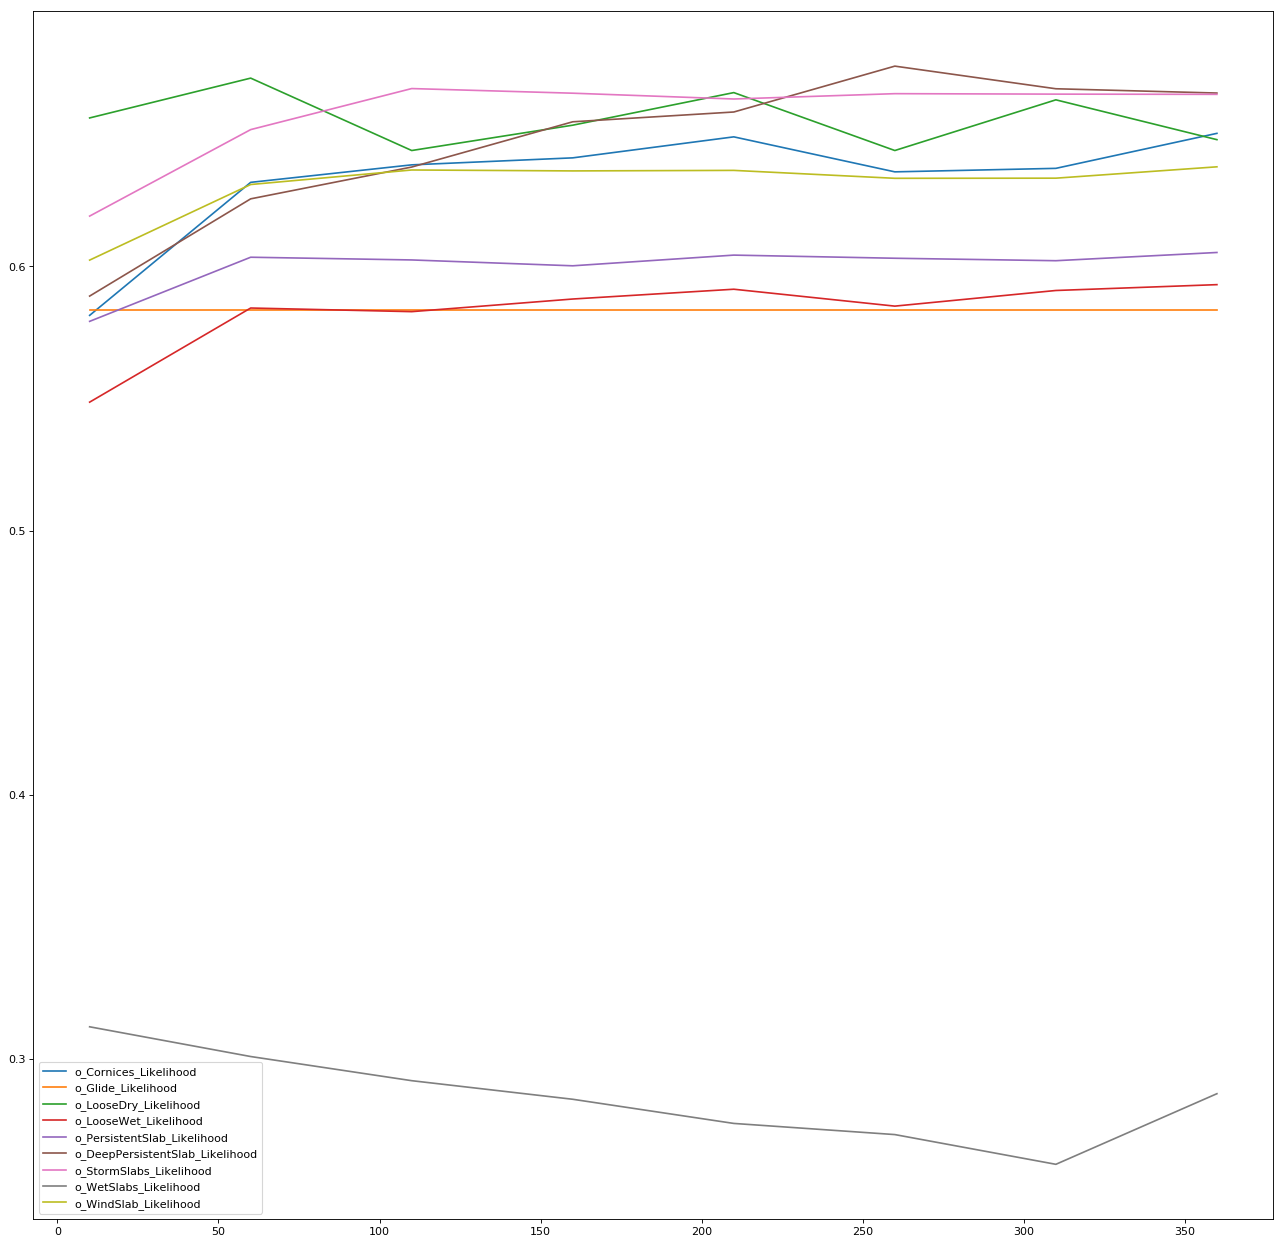

In [252]:
import matplotlib.pyplot as plt

plt.figure(num=1, figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')
for k in scores.keys():
    plt.plot([10, 60, 110, 160, 210, 260, 310, 360], scores[k])

#plt.legend(plt, "title", prop=fontP)
plt.legend(scores.keys())

In [20]:
for t in avy_problem_types:
    #preds = models[t].predict(dfs[t][1][columns_to_keep].values)
    s = models[t].score(dfs[t][1][columns_to_keep].values, dfs[t][1][yColumns].values.ravel())
    print(t + ": " + str(s))

NameError: name 'models' is not defined

In [21]:
#set best values 
best_estimators = {'o_Cornices_Likelihood':350, 'o_Glide_Likelihood':10, 'o_LooseDry_Likelihood':60, 
                   'o_LooseWet_Likelihood':350, 'o_PersistentSlab_Likelihood':60, 'o_DeepPersistentSlab_Likelihood':260,
                   'o_StormSlabs_Likelihood':110, 'o_WetSlabs_Likelihood':10, 'o_WindSlab_Likelihood':60}

In [22]:
final_models = {}
for t in avy_problem_types:       
    m = RandomForestClassifier(n_jobs = -1,                            
                               n_estimators=best_estimators[t],                               
                               min_samples_leaf=3,
                               class_weight = 'balanced'
                              )
    m.fit(dfs[t][0][columns_to_keep].values, dfs[t][0][yColumns].values.ravel())
    final_models[t] = m
    s = final_models[t].score(dfs[t][1][columns_to_keep].values, dfs[t][1][yColumns].values.ravel())
    print(t + ": " + str(s))

o_Cornices_Likelihood: 0.6476821192052981
o_Glide_Likelihood: 0.5836298932384342
o_LooseDry_Likelihood: 0.6328767123287671
o_LooseWet_Likelihood: 0.5906890575509472
o_PersistentSlab_Likelihood: 0.5976439622520383
o_DeepPersistentSlab_Likelihood: 0.6611895394584587
o_StormSlabs_Likelihood: 0.6704395893656225
o_WetSlabs_Likelihood: 0.26652601969057665
o_WindSlab_Likelihood: 0.6321457125724566


In [143]:

tmpdf = df[columns_to_keep + yColumns + metadata_columns].copy()
tmpdf.replace({'o_Day1DangerAboveTreeline': mapping}, inplace=True)        
df_test = tmpdf[tmpdf['Date'] > datetime.datetime(2017, 5, 1)]

In [144]:
synthetic_regions = ['Low West', 'Low East', 'In The Desert', 'In The Lake', 'Plains']
df_test = df_test[~df_test['UnifiedRegion'].isin(synthetic_regions)]

In [145]:
len(df_test)

67113

In [205]:
predictions = {}
probabilities = {}
max_proba_index = {}
for t in avy_problem_types:
    predictions[t] = final_models[t].predict(df_test[columns_to_keep].values)
    probabilities[t] = pd.DataFrame(final_models[t].predict_proba(df_test[columns_to_keep].values))
    max_proba_index[t] = probabilities[t].idxmax(axis=1)

In [243]:

probabilities['o_Glide_Likelihood'].loc[2][1]

0.8046632124352332

In [242]:
probabilities['o_Glide_Likelihood'].head()

,0,1,2
0,0.000000,1.000000,0.000000
1,0.200000,0.800000,0.000000
2,0.195337,0.804663,0.000000
3,0.095337,0.904663,0.000000
4,0.095337,0.834434,0.070229


In [208]:
probabilities['o_Cornices_Likelihood'].head()

,0,1,2,3
0,0.029816,0.451259,0.385325,0.133600
1,0.020347,0.590744,0.339062,0.049847
2,0.011979,0.499311,0.393019,0.095692
3,0.039771,0.453655,0.397599,0.108975
4,0.011957,0.574080,0.361316,0.052646


In [244]:
#find model with highest probability and choose that prediction
final_proba_predictions = [0] * len(probabilities['o_Cornices_Likelihood'])
for i in range(0,len(probabilities['o_Cornices_Likelihood'])):
    current_max_proba = 0
    current_max_prediction = 0
    for t in avy_problem_types:
        index_of_max_for_type = max_proba_index[t][i]
        prob = probabilities[t].loc[i][index_of_max_for_type]
        if(prob > current_max_proba):
            current_max_proba = prob
            current_max_prediction = max_proba_index[t][i]
    #print("index: " + str(i))
    final_proba_predictions[i] = current_max_prediction

In [246]:
len(final_proba_predictions)

67113

In [151]:
df_preds['max'] = df_preds.max(axis=1)

In [172]:
X_Above_test = df_test[columns_to_keep]
y_Above_test = df_test[yColumns+metadata_columns]

In [173]:
X_Above_test = X_Above_test.reset_index(drop=True)
y_Above_test = y_Above_test.reset_index(drop=True)

In [174]:
y_Above_test.tail()

,o_Day1DangerAboveTreeline,Lat,Lon,UnifiedRegion,Date,IsCriticalPoint
67108,3,48.986465,-121.322702,Cascade West - North,2018-01-30,False
67109,2,48.986465,-121.322702,Cascade West - North,2018-01-31,False
67110,2,48.986465,-121.322702,Cascade West - North,2018-02-01,False
67111,2,48.986465,-121.322702,Cascade West - North,2018-02-02,False
67112,2,48.986465,-121.322702,Cascade West - North,2018-02-03,False


In [175]:
len(df_test)

67113

In [176]:
len(X_Above_test)

67113

In [247]:
#preds = df_preds['max']
preds = final_proba_predictions

In [248]:
len(preds)

67113

In [216]:

#m = models[t]
#m.score(X_Above_test.values, y_Above_test[yColumns].values.ravel())


0.647945205479452

In [203]:
#only look at critical points
y_Above_test_crit = y_Above_test[y_Above_test['IsCriticalPoint']==True]
X_Above_test_crit = X_Above_test.loc[y_Above_test_crit.index, :]
preds_crit = m.predict(X_Above_test_crit)

In [204]:
#split in to forecast types
X_Above_test_cont = X_Above_test[X_Above_test['c_IsContenentalSnowpack']==True]
y_Above_test_cont = y_Above_test.loc[X_Above_test_cont.index, :]

X_Above_test_coast = X_Above_test[X_Above_test['c_IsCoastalSnowpack']==True]
y_Above_test_coast = y_Above_test.loc[X_Above_test_coast.index, :]

preds_cont = m.predict(X_Above_test_cont)
preds_coast = m.predict(X_Above_test_coast)

In [179]:
preds.values

array([2, 2, 2, ..., 2, 3, 3], dtype=int64)

In [58]:
len(y_Above_test)

67113

In [250]:
y_Above_test['Prediction'] = preds

In [181]:
len(y_Above_test)

67113

In [251]:
y_Above_test.tail()

,o_Day1DangerAboveTreeline,Lat,Lon,UnifiedRegion,Date,IsCriticalPoint,Prediction
67108,3,48.986465,-121.322702,Cascade West - North,2018-01-30,False,1
67109,2,48.986465,-121.322702,Cascade West - North,2018-01-31,False,1
67110,2,48.986465,-121.322702,Cascade West - North,2018-02-01,False,1
67111,2,48.986465,-121.322702,Cascade West - North,2018-02-02,False,1
67112,2,48.986465,-121.322702,Cascade West - North,2018-02-03,False,1


In [107]:
X_Above_test.tail()

,n_f_APCPsurface1HourForecast,n_f_10mWindSpeed1HourForecast,n_f_APCPsurface2HourForecast,n_f_10mWindSpeed2HourForecast,n_f_APCPsurface3HourForecast,n_f_10mWindSpeed3HourForecast,n_f_APCPsurface4HourForecast,n_f_10mWindSpeed4HourForecast,n_f_APCPsurface5HourForecast,n_f_10mWindSpeed5HourForecast,...,c_r_Prev7DayWindSlabLikeliness29InPast,c_r_Prev3DayFreezeThawLikeliness30InPast,c_r_Prev7DayFreezeThawLikeliness30InPast,c_r_Prev3DayWindSlabLikeliness30InPast,c_r_Prev7DayWindSlabLikeliness30InPast,c_IsCoastalSnowpack,c_IsContenentalSnowpack,AvyCenter,DayOfYear,DayOfSeason
338034,3.0625,4.982064,6.6875,5.520386,9.3125,5.240983,12.1875,5.562860,14.5000,6.195474,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,30.0,90.0
340506,0.2500,2.835830,0.8750,2.921923,1.9375,3.381995,3.8750,3.545835,5.1875,3.750230,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,31.0,91.0
342432,0.3750,2.706438,1.0625,3.300005,1.7500,3.590875,2.6250,3.498422,3.8125,3.439103,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,32.0,92.0
344343,0.1250,2.363804,0.3125,2.613523,0.6875,2.600542,1.2500,2.624445,1.6875,2.791102,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,33.0,93.0
346254,0.0625,4.426354,0.1875,4.246531,0.2500,4.058668,0.3750,4.016964,0.5000,3.843651,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,34.0,94.0


In [88]:
len(y_Above_test)

67113

In [52]:
#remove synthetic regions from the evaluation

synthetic_regions = ['Low West', 'Low East', 'In The Desert', 'In The Lake']
y_Above_test = y_Above_test[~y_Above_test['UnifiedRegion'].isin(synthetic_regions)]

In [85]:
y_Above_test['UnifiedRegion'].value_counts()

Cascade East - South           5576
Northern San Juan              5568
Olympics                       5440
Front Range                    5412
Cascade East - North           4896
Cascade East - Central         4760
Cascade West - South           4080
Cascade West - North           3882
Southern San Juan              3689
Vail & Summit County           2967
Sangre de Cristo               2730
Sawatch Range                  2660
Aspen                          2144
Uintas                         2071
Ogden                          1950
Cascade West - Central         1904
Gunnison                       1452
Logan                          1414
Steamboat & Flat Tops          1320
Skyline                        1040
Cascade Pass - Snoq. Pass       816
Mt Hood                         544
Salt Lake                       532
Cascade Pass - Stevens Pass     136
Provo                           130
Name: UnifiedRegion, dtype: int64

In [252]:
preds = y_Above_test['Prediction']

In [90]:
preds

2         2.0
3         2.0
2798      2.0
3192      1.0
5593      1.0
6377      1.0
8783      2.0
9407      2.0
11973     1.0
12352     2.0
15163     1.0
15297     2.0
18283     2.0
18482     1.0
21473     2.0
21628     2.0
24025     2.0
24120     1.0
26217     2.0
26668     1.0
28389     2.0
29160     3.0
30885     2.0
31320     1.0
33397     2.0
33872     2.0
35949     2.0
36384     1.0
38501     2.0
38936     2.0
         ... 
250967    NaN
254002    NaN
257032    NaN
260217    NaN
263287    NaN
266262    NaN
269447    NaN
272310    NaN
273796    NaN
275024    NaN
290860    NaN
293975    NaN
297160    NaN
300250    NaN
303435    NaN
306620    NaN
309685    NaN
312870    NaN
315985    NaN
319170    NaN
322355    NaN
325540    NaN
328725    NaN
331840    NaN
335025    NaN
338034    NaN
340506    NaN
342432    NaN
344343    NaN
346254    NaN
Name: Prediction, Length: 67113, dtype: float64

Accuracy: 0.49914323603474736
Classification Report
              precision    recall  f1-score   support

           0       0.49      0.03      0.05     12318
           1       0.50      0.99      0.66     33367
           2       0.49      0.01      0.03     18402
           3       0.56      0.00      0.01      3026

   micro avg       0.50      0.50      0.50     67113
   macro avg       0.51      0.26      0.19     67113
weighted avg       0.50      0.50      0.35     67113

Normalized confusion matrix
Confusion matrix, without normalization


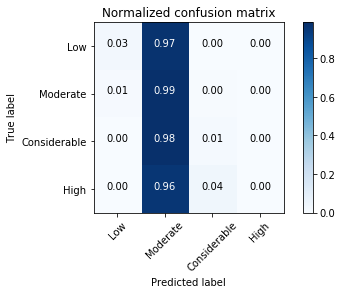

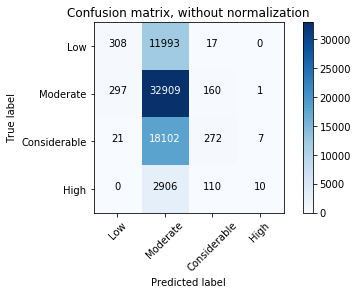

In [253]:
error_evaluation.evaluateSingleClassShort(y_Above_test['o_Day1DangerAboveTreeline'], preds)
cnf_matrix = confusion_matrix(y_Above_test['o_Day1DangerAboveTreeline'], preds)
plt.figure()
error_evaluation.plot_confusion_matrix(cnf_matrix, classes=['Low', 'Moderate', 'Considerable', 'High'], normalize=True,
                      title='Normalized confusion matrix')

plt.figure()
error_evaluation.plot_confusion_matrix(cnf_matrix, classes=['Low', 'Moderate', 'Considerable', 'High'],
                      title='Confusion matrix, without normalization')

Accuracy: 0.5990883995634589
Classification Report
              precision    recall  f1-score   support

Considerable       0.56      0.33      0.42      9481
        High       0.53      0.10      0.16       873
         Low       0.50      0.00      0.01      3434
    Moderate       0.61      0.89      0.72     17366

   micro avg       0.60      0.60      0.60     31154
   macro avg       0.55      0.33      0.33     31154
weighted avg       0.58      0.60      0.53     31154

Normalized confusion matrix
Confusion matrix, without normalization
Normalized confusion matrix
Confusion matrix, without normalization
Accuracy: 0.6196099243730927
Classification Report
              precision    recall  f1-score   support

Considerable       0.62      0.31      0.42      5616
        High       0.53      0.13      0.21       623
         Low       0.50      0.00      0.01      3434
    Moderate       0.62      0.94      0.75     12938

   micro avg       0.62      0.62      0.62     22611
 

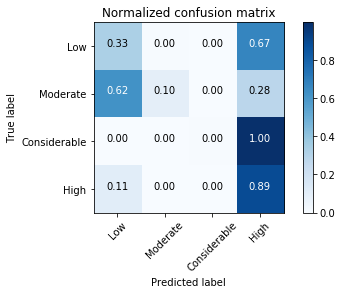

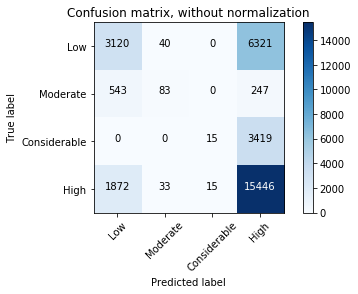

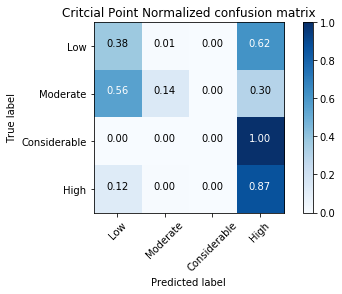

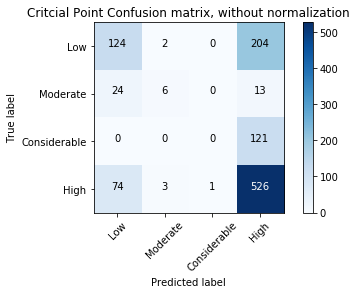

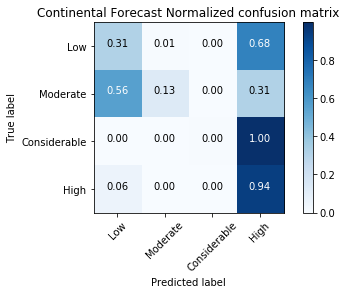

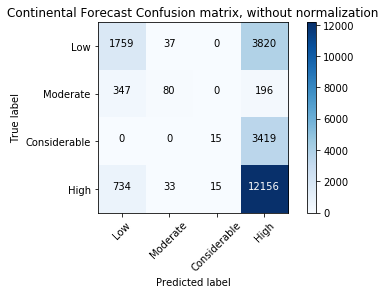

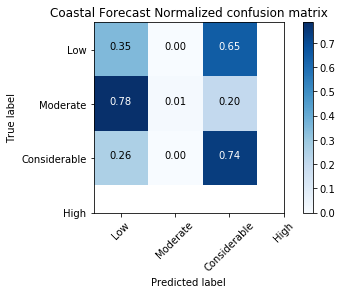

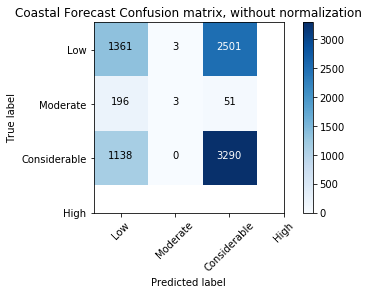

In [212]:

plt.figure()
cnf_matrix_crit = confusion_matrix(y_Above_test_crit['o_Day1DangerAboveTreeline'], preds_crit)

error_evaluation.plot_confusion_matrix(cnf_matrix_crit, classes=['Low', 'Moderate', 'Considerable', 'High'], normalize=True,
                      title='Critcial Point Normalized confusion matrix')
plt.figure()
error_evaluation.plot_confusion_matrix(cnf_matrix_crit, classes=['Low', 'Moderate', 'Considerable', 'High'],
                      title='Critcial Point Confusion matrix, without normalization')

plt.figure()
error_evaluation.evaluateSingleClassShort(y_Above_test_cont['o_Day1DangerAboveTreeline'], preds_cont)
cnf_matrix_cont = confusion_matrix(y_Above_test_cont['o_Day1DangerAboveTreeline'], preds_cont)

error_evaluation.plot_confusion_matrix(cnf_matrix_cont, classes=['Low', 'Moderate', 'Considerable', 'High'], normalize=True,
                      title='Continental Forecast Normalized confusion matrix')
plt.figure()
error_evaluation.plot_confusion_matrix(cnf_matrix_cont, classes=['Low', 'Moderate', 'Considerable', 'High'],
                      title='Continental Forecast Confusion matrix, without normalization')

plt.figure()
error_evaluation.evaluateSingleClassShort(y_Above_test_coast['o_Day1DangerAboveTreeline'], preds_coast)
cnf_matrix_coast = confusion_matrix(y_Above_test_coast['o_Day1DangerAboveTreeline'], preds_coast)

error_evaluation.plot_confusion_matrix(cnf_matrix_coast, classes=['Low', 'Moderate', 'Considerable', 'High'], normalize=True,
                      title='Coastal Forecast Normalized confusion matrix')
plt.figure()
error_evaluation.plot_confusion_matrix(cnf_matrix_coast, classes=['Low', 'Moderate', 'Considerable', 'High'],
                      title='Coastal Forecast Confusion matrix, without normalization')
plt.show()

In [ ]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

print(__version__)
init_notebook_mode(connected=True)

In [ ]:
to_plot = y_Above_test[y_Above_test['o_Day1DangerAboveTreeline']=='High']

data = [ dict(
        type = 'scattergeo',
        locationmode = 'USA-states',
        lat = to_plot['Lat'].values,
        lon = to_plot['Lon'].values,
        text = 'High',
        mode = 'markers',
        marker = dict(
            size = 1,
            opacity = 0.8,
            reversescale = True,
            autocolorscale = True,
            symbol = 'square',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            )
       
        ))]
layout = dict(
        title = 'Test Prediction Points',
        
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(217, 217, 217)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.5,
            subunitwidth = 0.5
        ),
    )

fig = dict( data=data, layout=layout )
iplot( fig )

In [ ]:
to_plot.to_csv("outsample.csv")

In [213]:
importances = pd.Series(m.feature_importances_)
out = pd.concat([pd.Series(X_Above_test.columns), importances], axis=1)
out.columns=['Feature','Score']

In [214]:
out.sort_values(by=['Score'], ascending=False)[:50]

,Feature,Score
18,n_f_APCPsurface10HourForecast,0.013075
12,n_f_APCPsurface7HourForecast,0.012873
65,n_r_Prev1DayPrecip,0.012552
55,n_r_Prev7daySnowAccumulation,0.012527
52,n_f_APCPsurface,0.010641
73,n_r_SNOWDAS_SolidPrecip_kgpersquarem,0.010033
20,n_f_APCPsurface11HourForecast,0.009795
86,n_r_Prev1dayMaxTemp1InPast,0.008285
10,n_f_APCPsurface6HourForecast,0.008203
865,DayOfSeason,0.008163


In [ ]:
out.sort_values(by=['Score'], ascending=False).plot.barh()
plt.show()

In [ ]:
important_features= out[out['Score'] > .001].sort_values(by=['Score'], ascending=False)['Feature']

In [ ]:
X_Above_test_imp = X_Above_test[important_features]
X_Above_train_imp = X_Above_train[important_features]

In [ ]:
m2 = RandomForestClassifier(n_jobs = -1,
                           oob_score=True,
                           n_estimators=500,
                           max_features="sqrt",
                           min_samples_leaf=3,   
                           )
m2.fit(X_Above_train_imp.values, y_Above_train['o_Day1DangerAboveTreeline'].values.ravel())
m2.score(X_Above_train_imp.values, y_Above_train['o_Day1DangerAboveTreeline'].values.ravel())

In [ ]:
preds2 = m2.predict(X_Above_test_imp)

In [ ]:
error_evaluation.evaluateSingleClassShort(y_Above_test_imp['o_Day1DangerAboveTreeline'], preds2)
cnf_matrix = confusion_matrix(y_Above_test_imp['o_Day1DangerAboveTreeline'], preds2)
plt.figure()
error_evaluation.plot_confusion_matrix(cnf_matrix, classes=['Low', 'Moderate', 'Considerable', 'High'], normalize=True,
                      title='Normalized confusion matrix')

plt.figure()
error_evaluation.plot_confusion_matrix(cnf_matrix, classes=['Low', 'Moderate', 'Considerable', 'High'],
                      title='Confusion matrix, without normalization')

In [ ]:
importances2 = pd.Series(m2.feature_importances_)
out = pd.concat([pd.Series(X_Above_train_imp.columns), importances2], axis=1)
out.columns=['Feature','Score']

In [ ]:
out.sort_values(by=['Score'], ascending=False)[:10]

In [ ]:
out.sort_values(by=['Score'], ascending=False).plot.barh()
plt.show()

In [ ]:
import re
for x in range(1, 15):
    subset_cols = ['DayOfYear',
    'c_IsContenentalSnowpack',
    'c_IsCoastalSnowpack',
    'n_f_APCPsurface1HourForecast',
    'n_f_10mWindSpeed1HourForecast',
    'n_f_APCPsurface2HourForecast',
    'n_f_10mWindSpeed2HourForecast',
    'n_f_APCPsurface3HourForecast',
    'n_f_10mWindSpeed3HourForecast',
    'n_f_APCPsurface4HourForecast',
    'n_f_10mWindSpeed4HourForecast',
    'n_f_APCPsurface5HourForecast',
    'n_f_10mWindSpeed5HourForecast',
    'n_f_APCPsurface6HourForecast',
    'n_f_10mWindSpeed6HourForecast',
    'n_f_APCPsurface7HourForecast',
    'n_f_10mWindSpeed7HourForecast',
    'n_f_APCPsurface8HourForecast',
    'n_f_10mWindSpeed8HourForecast',
    'n_f_APCPsurface9HourForecast',
    'n_f_10mWindSpeed9HourForecast',
    'n_f_APCPsurface10HourForecast',
    'n_f_10mWindSpeed10HourForecast',
    'n_f_APCPsurface11HourForecast',
    'n_f_10mWindSpeed11HourForecast',
    'n_f_APCPsurface12HourForecast',
    'n_f_10mWindSpeed12HourForecast',
    'n_f_APCPsurface13HourForecast',
    'n_f_10mWindSpeed13HourForecast',
    'n_f_APCPsurface14HourForecast',
    'n_f_10mWindSpeed14HourForecast',
    'n_f_APCPsurface15HourForecast',
    'n_f_10mWindSpeed15HourForecast',
    'n_f_APCPsurface16HourForecast',
    'n_f_10mWindSpeed16HourForecast',
    'n_f_APCPsurface17HourForecast',
    'n_f_10mWindSpeed17HourForecast',
    'n_f_APCPsurface18HourForecast',
    'n_f_10mWindSpeed18HourForecast',
    'n_f_APCPsurface19HourForecast',
    'n_f_10mWindSpeed19HourForecast',
    'n_f_APCPsurface20HourForecast',
    'n_f_10mWindSpeed20HourForecast',
    'n_f_APCPsurface21HourForecast',
    'n_f_10mWindSpeed21HourForecast',
    'n_f_APCPsurface22HourForecast',
    'n_f_10mWindSpeed22HourForecast',
    'n_f_APCPsurface23HourForecast',
    'n_f_10mWindSpeed23HourForecast',
    'n_f_tempMaxF',
    'n_f_10mWindSpeedMax',
    'n_r_snowDepthIn',
    'n_f_tempMinF',
    'n_f_tempAveF',
    'n_f_10mWindSpeed',
    'n_f_APCPsurface',
    'n_r_precipIncrementSnowIn',
    'n_r_Prev3daySnowAccumulation',
    'n_r_Prev7daySnowAccumulation',
    'n_r_Prev3dayMaxTemp',
    'n_r_Prev3DayMax10mWind',
    'n_r_Prev3dayMinTemp',
    'n_r_Prev7dayMaxTemp',
    'n_r_Prev7DayMax10mWind',
    'n_r_Prev7dayMinTemp',
    'n_r_Prev1dayMaxTemp',
    'n_r_Prev1DayMax10mWind',
    'n_r_Prev1dayMinTemp',
    'n_r_Prev1DayPrecip',
    'n_f_Next24HourChangeInTempFromPrev3DayMax',
    'n_f_Next24HoursChangeInTempFromPrev1DayMax',
    'n_r_Prev24HoursPrecipAsRainTotalIn',
    'n_r_SNOWDAS_SnowDepth_mm',
    'n_r_SNOWDAS_SWE_mm',
    'n_r_SNOWDAS_SnowmeltRunoff_micromm',
    'n_r_SNOWDAS_Sublimation_micromm',
    'n_r_SNOWDAS_SolidPrecip_kgpersquarem',
    'n_r_SNOWDAS_LiquidPrecip_kgpersquarem',
    'n_r_SNOWDAS_SnowpackAveTemp_k']
    for y in range(1, x):
        day_regex = ""
        #print("loop x: " + str(x) + " y: " + str(y))
        expression = '.+\D'+str(y)+'InPast'
        #print("e:"+expression)
        day_regex = re.compile(expression)
        match_cols = list(filter(day_regex.match, cols))
        #print("match len: " + str(len(match_cols)))
        subset_cols = subset_cols + match_cols
    print("Have len: " + str(len(subset_cols)))
    ds = X_Near_train[subset_cols]
    ds_test = X_Near_test[subset_cols]
    m3 = RandomForestClassifier(n_jobs = -1,
                           oob_score=True,
                           n_estimators=500,
                           max_features="sqrt"
                           )
    m3.fit(ds.values, y_Near_train['o_Day1DangerNearTreeline'].values.ravel())
    preds3 = m3.predict(ds_test)
    error_evaluation.evaluateSingleClassShort(y_Near_test['o_Day1DangerNearTreeline'], preds3)
    
    

In [ ]:
import matplotlib.pyplot as plt

from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# Author: Kian Ho <hui.kian.ho@gmail.com>
#         Gilles Louppe <g.louppe@gmail.com>
#         Andreas Mueller <amueller@ais.uni-bonn.de>
#
# License: BSD 3 Clause

print(__doc__)

RANDOM_STATE = 123

# Generate a binary classification dataset.
#X, y = make_classification(n_samples=500, n_features=25,
#                           n_clusters_per_class=1, n_informative=15,
#                           random_state=RANDOM_STATE)
X = X_Above_train
y = y_Above_train[yColumns]

# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(n_estimators=100,
                               warm_start=True, oob_score=True,
                               max_features="sqrt",
                               n_jobs = 3,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(n_estimators=100,
                               warm_start=True, max_features='log2',
                               n_jobs = 3,
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(n_estimators=100,
                               warm_start=True, max_features=None,
                               n_jobs=3,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 15
max_estimators = 500

for label, clf in ensemble_clfs:
    i = min_estimators
    for i in range(min_estimators, max_estimators + 1, 25):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

In [ ]:

lat_lon_cache = pd.read_csv('../Data/LatLonCache.csv')
def find_nearest_forecast_point(row):
    
    tmp_lat_lon_cache = lat_lon_cache.copy()
   
    #TODO: currently a simple esitmate for converting lon to miles, 53 degrees per mile--need to do better for the real deal
    tmp_lat_lon_cache['distance'] = np.sqrt(np.square(69.0*(lat_lon_cache['Lat']-row['Lat'])) + np.square(53.0*(lat_lon_cache['Lon']-row['Lon'])))
    #tmp_lat_lon_cache['distance'] = tmp_lat_lon_cache[:3].apply(lambda x: estimate_distance_between_points_mi(lat, lon, x['Lat'], x['Lon']), axis=1)
    print("after distance calc")
    #nearest point needs to be within 20 miles
    nearest_row = tmp_lat_lon_cache.sort_values(by=['distance']).iloc[0, :]
    if nearest_row['distance'] > 20.0:
        #should never happen since our grid is smaller but just in case
        return -1, -1
    else:
        return nearest_row['Lat'], nearest_row['Lon']

In [ ]:
def is_critical_point(row, critical_points):
    for cp in critical_points:
        if(row['Lat'] == cp[0] and row['Lon'] == cp[1]):
            return True
    return False

lat_lon_cache = pd.read_csv('../Data/LatLonCache.csv')
critical_points = pd.read_csv('../Data/CriticalPointsToForecast.csv')
critical_forecast_points = critical_points.apply(find_nearest_forecast_point, axis=1)




        

In [ ]:

#X_Above_test, X_Above_train, y_Above_test, y_Above_train
tmp = y_Above_test.apply(lambda x: is_critical_point(x, critical_forecast_points), axis=1)


In [ ]:
tmp.value_counts()

In [ ]:
lat_lon_cache = pd.read_csv('../Data/LatLonCache.csv')

In [ ]:
critical_points = pd.read_csv('../Data/CriticalPointsToForecast.csv')

In [ ]:
lat_lon_cache.columns

In [ ]:
np.sqrt(np.square(69.0*(lat_lon_cache['Lat']-47.981010)) + np.square(53.0*(lat_lon_cache['Lon']--123.472400)))